In [ ]:
pip install pydicom nibabel numpy torch torchvision segmentation-models-pytorch scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e252a2210aa22e8cd7ca4542fa64990ad19b676b7d22590cc61b96cbe04637c3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=b578a09f21602ae8e6af95789f52e44b9e9ec180c442543528128838fb88daaa
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytor

Train Set Samples:
Validation Set Samples:
Test Set Samples:


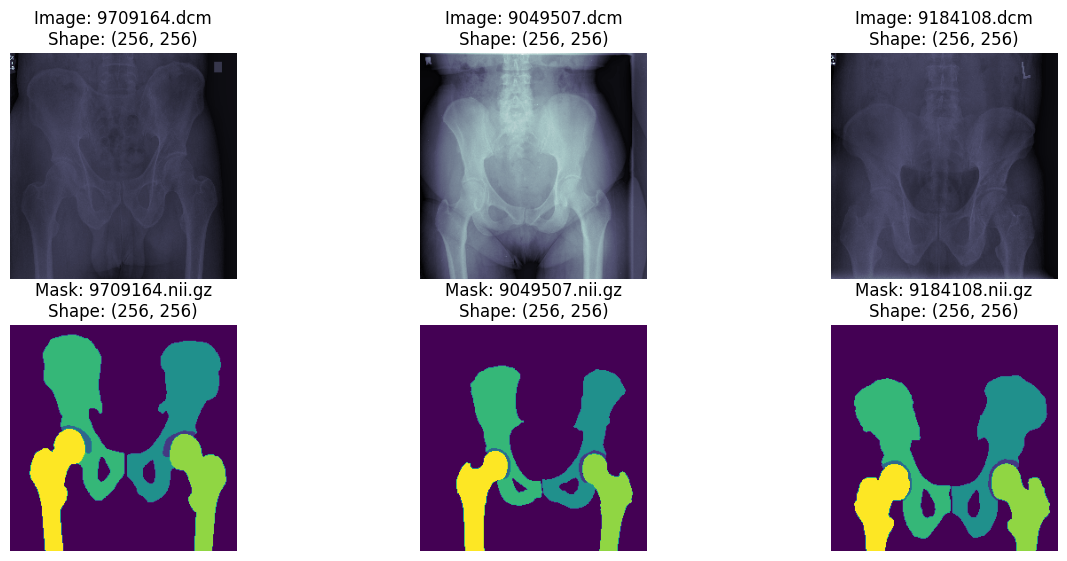

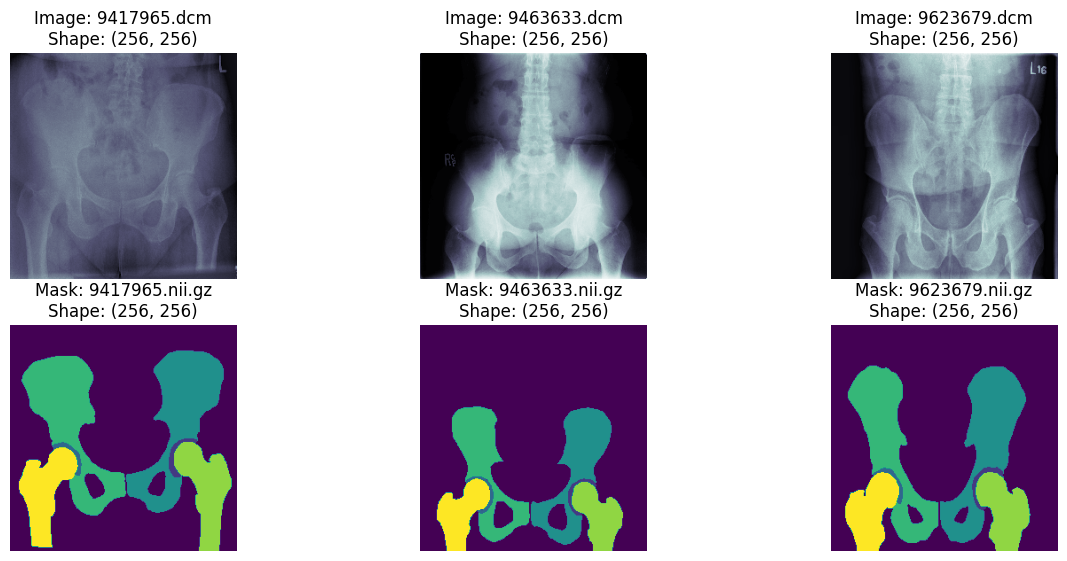

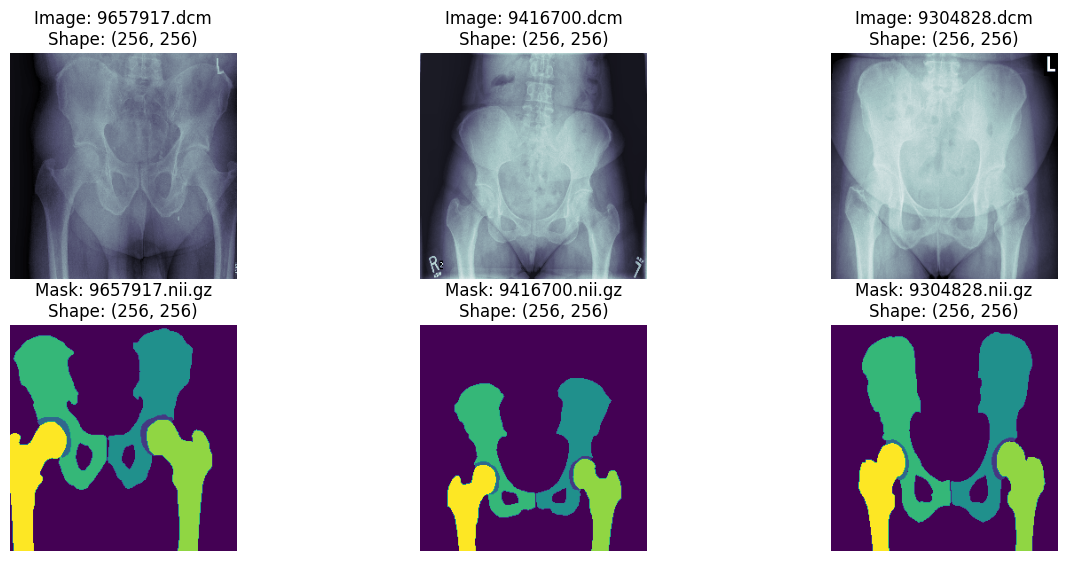

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import random
img_root = "JHIR_Hip_Knee_Datasets/Hip/Images"
mask_root = "JHIR_Hip_Knee_Datasets/Hip/Annotations"
class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=3)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]
        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask

image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))
paired_files = list(zip(image_files, mask_files))
random.shuffle(paired_files)

train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

num_classes = 7

augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)

train_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in train_pairs], [p[1] for p in train_pairs], num_classes, transforms=augmentations)
valid_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in valid_pairs], [p[1] for p in valid_pairs], num_classes, transforms=augmentations)
test_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in test_pairs], [p[1] for p in test_pairs], num_classes, transforms=augmentations)

def visualize_samples(dataset, num_samples=3, img_cmap='bone'):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        image, mask = dataset[i]
        image_np = image.squeeze().numpy()
        mask_np = mask.argmax(axis=0)

        img_filename = dataset.img_files[i]
        mask_filename = dataset.mask_files[i]

        plt.subplot(3, num_samples, i + 1)
        plt.imshow(image_np, cmap=img_cmap)
        plt.axis('off')
        plt.title(f'Image: {img_filename}\nShape: {image_np.shape}')

        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(mask_np, cmap='viridis', vmin=0, vmax=dataset.num_classes - 1)
        plt.axis('off')
        plt.title(f'Mask: {mask_filename}\nShape: {mask_np.shape}')

print("Train Set Samples:")
visualize_samples(train_set, num_samples=3)
print("Validation Set Samples:")
visualize_samples(valid_set, num_samples=3)
print("Test Set Samples:")
visualize_samples(test_set, num_samples=3)

plt.show()


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 1/15, Training IoU: 0.34449038166991053


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 1/15, Validation IoU: 0.5273329332470894


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 2/15, Training IoU: 0.5575866714558181


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 2/15, Validation IoU: 0.5958534121513367


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 3/15, Training IoU: 0.5987634702640421


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 3/15, Validation IoU: 0.6321735620498657


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 4/15, Training IoU: 0.6347613772925209


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 4/15, Validation IoU: 0.6700229704380035


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 5/15, Training IoU: 0.674820692223661


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 5/15, Validation IoU: 0.6912229776382446


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 6/15, Training IoU: 0.7079934192930951


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 6/15, Validation IoU: 0.7484287649393082


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 7/15, Training IoU: 0.7618213962106144


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 7/15, Validation IoU: 0.7758004784584045


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 8/15, Training IoU: 0.7811300631831674


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 8/15, Validation IoU: 0.7837210714817047


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 9/15, Training IoU: 0.8251357963856529


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 9/15, Validation IoU: 0.8204435557126999


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 10/15, Training IoU: 0.8453332475003075


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 10/15, Validation IoU: 0.8194661140441895


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 11/15, Training IoU: 0.8493806001018075


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 11/15, Validation IoU: 0.8348972409963608


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 12/15, Training IoU: 0.8652208079310024


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 12/15, Validation IoU: 0.8222655326128006


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 13/15, Training IoU: 0.8745033618281869


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 13/15, Validation IoU: 0.8490679413080215


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 14/15, Training IoU: 0.8743211364044863


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 14/15, Validation IoU: 0.8571371793746948


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 15/15, Training IoU: 0.8798240541535265


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 15/15, Validation IoU: 0.8520843029022217


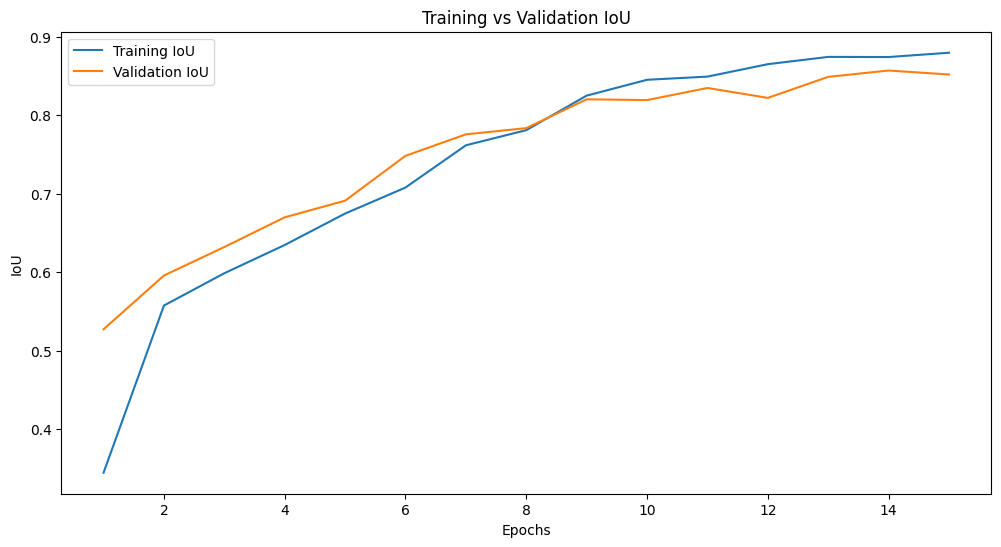

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import random
import segmentation_models_pytorch as smp

def compute_iou(pred, target, num_classes):
    pred = (pred > 0.5).float()
    intersection = torch.sum(pred * target, dim=(1, 2))
    union = torch.sum((pred + target) > 0, dim=(1, 2))
    iou = (intersection + 1e-10) / (union + 1e-10)
    return torch.mean(iou).item()

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=3)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask



image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))
paired_files = list(zip(image_files, mask_files))
random.shuffle(paired_files)


train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

num_classes = 7


augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)


train_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in train_pairs], [p[1] for p in train_pairs], num_classes, transforms=augmentations)
valid_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in valid_pairs], [p[1] for p in valid_pairs], num_classes, transforms=augmentations)
test_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in test_pairs], [p[1] for p in test_pairs], num_classes, transforms=augmentations)


model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=num_classes,
)


optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 15

train_ious = []
valid_ious = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=False, num_workers=2)

for epoch in range(num_epochs):
    model.train()
    train_epoch_iou = 0

    for batch in train_loader:
        images, masks = batch
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)
        train_epoch_iou += batch_iou

    train_epoch_iou /= len(train_loader)
    train_ious.append(train_epoch_iou)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training IoU: {train_epoch_iou}")

    model.eval()
    valid_epoch_iou = 0

    with torch.no_grad():
        for batch in valid_loader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)

            valid_epoch_iou += batch_iou

    valid_epoch_iou /= len(valid_loader)
    valid_ious.append(valid_epoch_iou)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation IoU: {valid_epoch_iou}")

torch.save(model.state_dict(), 'unet_resnet18_multiclass_model_weights.pth')

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_ious, label='Training IoU')
plt.plot(range(1, num_epochs + 1), valid_ious, label='Validation IoU')
plt.title('Training vs Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


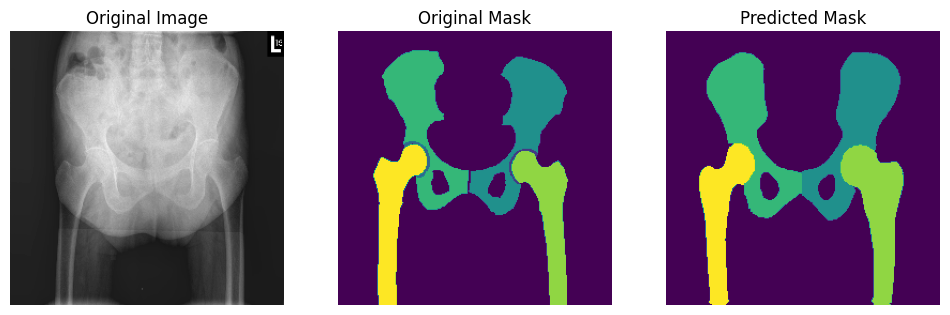

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

test_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in test_pairs], [p[1] for p in test_pairs], num_classes, transforms=augmentations)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

def visualize_single_sample(test_loader, model):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            images, masks = batch
            outputs = model(images)
            original_mask = torch.argmax(masks.squeeze(0), dim=0).cpu().numpy()
            predicted_mask = torch.argmax(outputs.squeeze(0), dim=0).cpu().numpy()
            image = images.squeeze(0).permute(1, 2, 0).cpu().numpy()

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(original_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
            plt.title('Original Mask')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()
            break

visualize_single_sample(test_loader, model)


In [ ]:
test_ious = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)
        test_ious.append(batch_iou)

test_mean_iou = np.mean(test_ious)

print(f"Test Mean IoU: {test_mean_iou}")


Test Mean IoU: 0.9183396114072492
